# Import necessary modules

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import albumentations as A
from albumentations.pytorch import ToTensorV2 as TTV2
import cv2

import os
import time

import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Create paths to training images, testing images & pre-trained models

In [2]:
data_path  = '../input/ranzcr-clip-catheter-line-classification/'
train_path = '../input/ranzcr-clip-catheter-line-classification/train/'
test_path  = '../input/ranzcr-clip-catheter-line-classification/test/'
#model_path = '../input/vitbase16384/jx_vit_base_p16_384-83fb41ba.pth' #ViTBase_16_384
model_path = '../input/vitbaseresnet50384/jx_vit_base_resnet50_384-9fd3c705.pth'
RANZCR_model_pretrained = ''

# Read training data csv file into pandas dataframe

In [3]:
df_all = pd.read_csv(data_path + 'train.csv')

# Create plot of df_train column totals

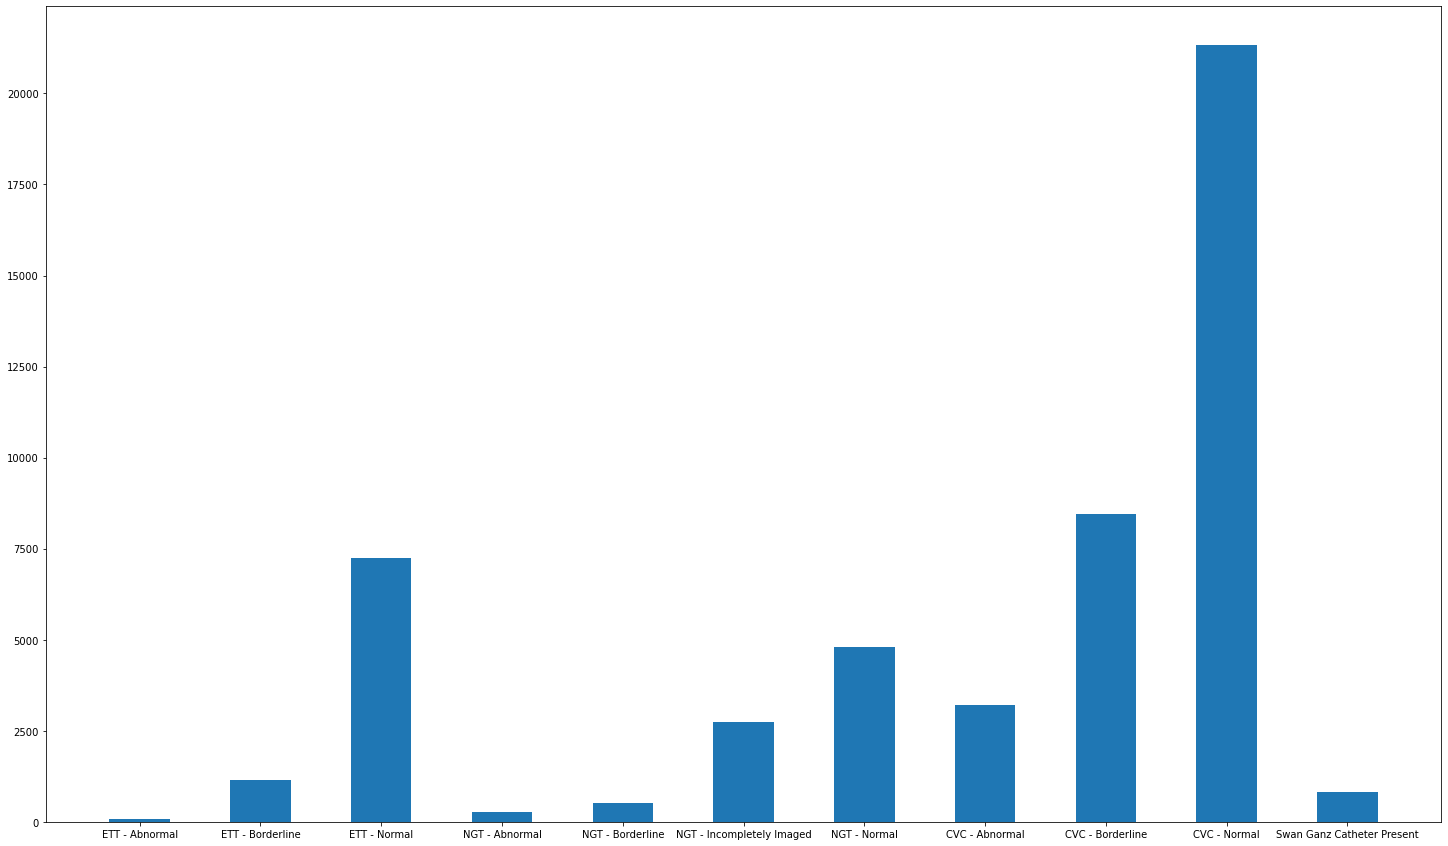

In [4]:
Instance_Totals = {'ETT - Abnormal':0,'ETT - Borderline':0, 'ETT - Normal':0, 'NGT - Abnormal':0, 'NGT - Borderline':0, 'NGT - Incompletely Imaged':0, 'NGT - Normal':0, 'CVC - Abnormal':0, 'CVC - Borderline':0, 'CVC - Normal':0, 'Swan Ganz Catheter Present':0}
for key in Instance_Totals.keys():
    Instance_Totals[key] = df_all[key].sum()
keys = Instance_Totals.keys()
values = Instance_Totals.values()
plt.rcParams["figure.figsize"] = (25,15)
plt.bar(keys, values, width=0.5)
plt.show()

# Determine how many unique patient IDs are present in the training set

In [5]:
print("Unique Patients = " + str(df_all['PatientID'].unique().shape[0]))

Unique Patients = 3255


# Set the training/validation data split

In [6]:
train_percent = 0.95
train_size = int(train_percent * len(df_all))
val_size = len(df_all) - train_size
print("Number of training examples   = ", train_size)
print("Number of validation examples = ", val_size)

Number of training examples   =  28578
Number of validation examples =  1505


# Split the data into the training and validation sets

In [7]:
train_df, valid_df = model_selection.train_test_split(df_all, test_size=val_size, random_state=42)

# Create RANZCRDataset class to load data
# y_label needs 11 values as this is multi-class classification problem

In [8]:
class RANZCRDataset(Dataset):    
    
    def __init__(self, df, root_dir, train_dir, transform=None):
        super().__init__()
        self.df_data = df
        self.root_dir = root_dir
        self.train_dir = train_dir
        self.transform = transform

    def __len__(self):
        return len(self.df_data)
       
    def __getitem__(self, idx):
        image_path = self.train_dir + self.df_data.iloc[idx,0] +'.jpg'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
            
        y_label = [int(self.df_data.iloc[idx, 1]),
                   int(self.df_data.iloc[idx, 2]),
                   int(self.df_data.iloc[idx, 3]),
                   int(self.df_data.iloc[idx, 4]),
                   int(self.df_data.iloc[idx, 5]),
                   int(self.df_data.iloc[idx, 6]),
                   int(self.df_data.iloc[idx, 7]),
                   int(self.df_data.iloc[idx, 8]),
                   int(self.df_data.iloc[idx, 9]),
                   int(self.df_data.iloc[idx, 10]),
                   int(self.df_data.iloc[idx, 11])]
        y_label_tensor = torch.tensor(y_label)
        
        return (image, y_label_tensor)

# Define dataset training and validation set transforms

In [9]:
train_transforms = A.Compose([
            A.Resize(384,384),
            A.Transpose(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5,border_mode=cv2.BORDER_CONSTANT),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            A.CoarseDropout(p=0.5),
            TTV2()])

val_transforms = A.Compose([
          A.Resize(384,384),
          A.Transpose(p=0.5),
          A.VerticalFlip(p=0.5),
          A.ShiftScaleRotate(p=0.5,border_mode=cv2.BORDER_CONSTANT),
          A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
          TTV2()])

# Load training and validation datasets

In [10]:
train_set = RANZCRDataset(train_df, data_path, train_path, transform=train_transforms)
val_set   = RANZCRDataset(valid_df, data_path, train_path, transform=train_transforms)

# Create training and validation batches (pin_memory = True to enable GPU)

In [11]:
torch.manual_seed(42)
batch_size = 16
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_loader   = DataLoader(dataset=val_set,   batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

# Check train_loader is working

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]])


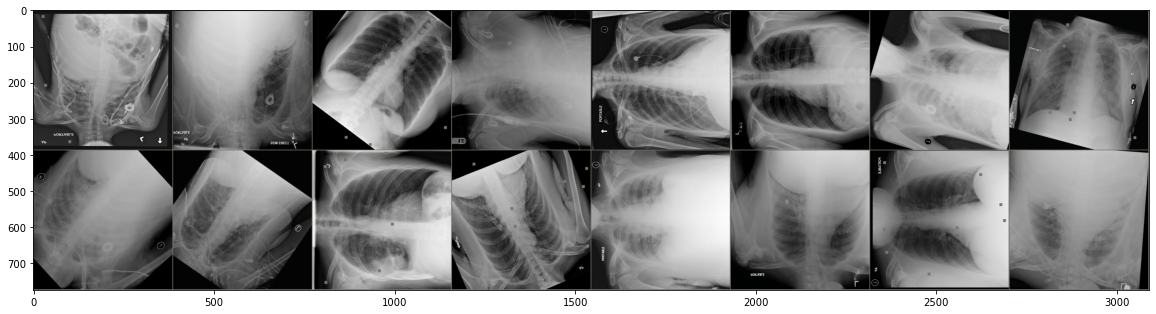

In [12]:
print(train_loader)

for images, labels in train_loader: 
    break

im= make_grid(images, nrow=8)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)

print(labels)

plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check val_loader is working

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


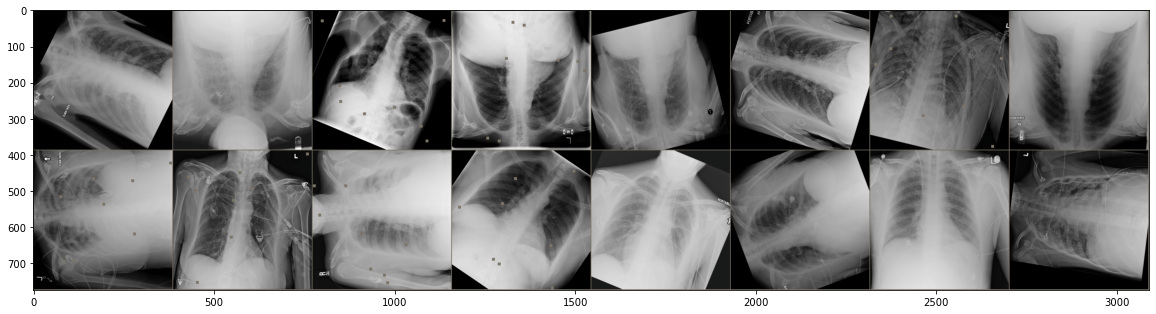

In [13]:
print(val_loader)

for images, labels in val_loader: 
    break

im= make_grid(images, nrow=8)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)

print(labels)

plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Install timm to access EfficientNet PyTorch Models

In [14]:
pip install '../input/timm034/timm-0.3.4-py3-none-any.whl'

Processing /kaggle/input/timm034/timm-0.3.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


# Import timm

In [24]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


# Display available ViT models

In [25]:
print("Available Vision Transformer Models: ")
timm.list_models("*384")

Available Vision Transformer Models: 


['vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_huge_patch32_384',
 'vit_large_patch16_384',
 'vit_large_patch32_384']

# Define ViTBase_16_384 class 

In [19]:
'''class ViTBase_16_384(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase_16_384, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_384", pretrained=False)
        
        if pretrained:
            self.model.load_state_dict(torch.load(model_path))
            
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)
        
    def forward(self, X):
        X = self.model(X)
        return X'''

# Create pre-trained ViTBase_16_384 model instance (11 classes)

In [ ]:
'''RANZCR_model = ViTBase_16_384(n_classes=11, pretrained=True)
#RANZCR_model.load_state_dict(torch.load(RANZCR_model_pretrained))
RANZCR_gpu_model = RANZCR_model.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(RANZCR_gpu_model.parameters(), lr=3.50e-04)
RANZCR_gpu_model'''

# Define ViTBase_ResNet50_16_384 class

In [22]:
class ViTBase_ResNet50_16_384(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase_ResNet50_16_384, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_384", pretrained=False)
        
        if pretrained:
            self.model.load_state_dict(torch.load(model_path))
            
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)
        
    def forward(self, X):
        X = self.model(X)
        return X

In [23]:
RANZCR_model = ViTBase_ResNet50_16_384(n_classes=11, pretrained=True)
#RANZCR_model.load_state_dict(torch.load(RANZCR_model_pretrained))
RANZCR_gpu_model = RANZCR_model.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(RANZCR_gpu_model.parameters(), lr=3.50e-04)
RANZCR_gpu_model

ModuleAttributeError: 'ViTBase_ResNet50_16_384' object has no attribute 'model'

# Train the model using GPU

In [ ]:
epochs = 4
start_epoch = 0

max_trn_batch = 1000000
max_val_batch = 1000000

train_losses = []
val_losses = []
batch_train_losses = []
batch_val_losses = []
train_score = []
val_score = []

for i in range(epochs):
    # Initialise epoch start time
    tic = time.time()
    # Initialise epoch losses to zero
    total_train_loss = 0
    total_val_loss = 0 
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_train = y_train.type(torch.cuda.FloatTensor)
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = RANZCR_gpu_model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Append batch training loss to list
        batch_train_losses.append(loss.item())
        # Keep track of total training loss
        total_train_loss += loss.item()
         
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        # Create arrays in order to calculate training AOC ROC score. Note that these arrays need to be created in order to avoid AOC ROC calculation error due to empty columns
        # Prudent to check that training data set does not contain empty columns
        train_predicted = torch.sigmoid(y_pred.data)
        if b == 1:
            y_train_true_arr_epoch = y_train.cpu().detach().numpy()
            y_train_pred_arr_epoch = train_predicted.cpu().detach().numpy()
        if b > 1:
            y_train_true_arr_epoch = np.vstack((y_train_true_arr_epoch, y_train.cpu().detach().numpy()))
            y_train_pred_arr_epoch = np.vstack((y_train_pred_arr_epoch, train_predicted.cpu().detach().numpy()))

        # Print interim results
        if b%(1*batch_size) == 0:
            print('*****************************************************************************************************************')
            print(f'EPOCH: {(i+start_epoch):2}        BATCH: {b:4} [{batch_size*b:6}/{train_size}]  BATCH LOSS: {loss.item():10.8f}   TIME: {((time.time()-tic)/60):5.2f} mins')
    
    # Append average training loss of epoch to list
    train_losses.append(total_train_loss/(b))
    # Calculate training AOC_ROC (multi-label setting used as shape of array is (n_samples, n_classes))
    train_AOC_ROC = metrics.roc_auc_score(y_train_true_arr_epoch,y_train_pred_arr_epoch)
    # Append training AOC ROC score to list
    train_score.append(train_AOC_ROC)
    
    print('*****************************************************************************************************************')
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(f'TRAINING LOSS EPOCH {(i+start_epoch):2} = {train_losses[i]:10.8f}  TRAINING AOC ROC SCORE = {train_score[i]:10.8f}  TIME FOR EPOCH {((time.time()-tic)/60):5.2f} mins   ')
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    model_file_name = 'RANZCR_ViT384_BCEWLL_GradAllLayers_TP95_Epochs' + str(i+start_epoch) +'.pt'
    torch.save(RANZCR_gpu_model.state_dict(), model_file_name)
    
    # Turn gradient descent off
    with torch.no_grad():
        for b_val, (X_val, y_val) in enumerate(val_loader):
            X_val = X_val.cuda()
            y_val = y_val.cuda()
            y_val = y_val.type(torch.cuda.FloatTensor)
        
            # Limit the number of batches
            if b_val == max_val_batch:
                break
            b_val+=1
        
            # Apply the model
            y_pred = RANZCR_gpu_model(X_val)
            loss = criterion(y_pred, y_val)
            
            # Create arrays in order to calculate validation AOC ROC score. Note that these arrays need to be created in order to avoid AOC ROC calculation error due to empty columns
            # Prudent to check that validation data set does not contain empty columns
            val_predicted = torch.sigmoid(y_pred.data)
            if b_val == 1:
                y_val_true_arr_epoch = y_val.cpu().detach().numpy()
                y_val_pred_arr_epoch = val_predicted.cpu().detach().numpy()
            if b_val > 1:
                y_val_true_arr_epoch = np.vstack((y_val_true_arr_epoch, y_val.cpu().detach().numpy()))
                y_val_pred_arr_epoch = np.vstack((y_val_pred_arr_epoch, val_predicted.cpu().detach().numpy()))
            
            # Append batch validation loss to list
            batch_val_losses.append(loss.item())
            # Keep track of total validation loss
            total_val_loss += loss.item()

            if b_val%(1*batch_size) == 0:
                print('*****************************************************************************************************************')
                print(f'EPOCH: {(i+start_epoch):2}        VAL BATCH: {b_val:4} [{batch_size*b_val:6}/{val_size}]  VALL BATCH LOSS: {loss.item():10.8f}   TIME: {((time.time()-tic)/60):5.2f} mins')
        
        # Append average validation loss of epoch to list
        val_losses.append(total_val_loss/(b_val))
        # Append average validation loss of epch to list
        val_AOC_ROC = metrics.roc_auc_score(y_val_true_arr_epoch,y_val_pred_arr_epoch)
        # Append training AOC ROC score to list
        val_score.append(train_AOC_ROC)
    
        print('*****************************************************************************************************************')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(f'VAL LOSS EPOCH {(i+start_epoch):2} = {val_losses[i]:10.8f}  VAL AOC ROC SCORE = {val_score[i]:10.8f}  TIME FOR VAL EPOCH {((time.time()-tic)/60):5.2f} mins   ')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

*****************************************************************************************************************
EPOCH:  0        BATCH:   16 [   256/300]  BATCH LOSS: 0.26126111   TIME:  0.33 mins
*****************************************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
TRAINING LOSS EPOCH  0 = 0.35119728  TRAINING AOC ROC SCORE = 0.46650448  TIME FOR EPOCH  0.38 mins   
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*****************************************************************************************************************
EPOCH:  0        VAL BATCH:   16 [   256/29783]  VALL BATCH LOSS: 0.28343821   TIME:  0.65 mins
*****************************************************************************************************************
EPOCH:  0        VAL BATCH:   32

# Plot training losses

In [ ]:
plt.plot(train_losses)

# Plot training AUC ROC score

In [ ]:
plt.plot(train_score)

# Plot validation losses

In [ ]:
plt.plot(val_losses)

# Plot validation AUC ROC score

In [ ]:
plt.plot(val_score)

# Save training losses & validation losses to .csv file

In [ ]:
df_results = pd.DataFrame(data={'Training_Loss': train_losses, 'Training_AOCROC': train_score, 'Validation_Loss': val_losses, 'Validation_AOCROC': val_score})
df_results.to_csv("InterimResults.csv", sep=',',index=False)